# Using K-Nearest Neighbor Classification to Predict Tennis Player Success: A Study of Title Wins



### Introduction

Tennis is a sport played globally between individuals competing within varying levels of skill ranging from beginner to professional-level play. Thus it is clear that there exists a strong global interest worth allocating resources and time on to answer a predictive question.

Utilizing classification, we aim to answer a predictive question regarding if a player holds one or more titles (i.e. if they have won one or more tournaments) based on the top 500 tennis player stats dataset. The question we aim to answer is: **Does the tennis player hold one or more titles given their best rank, number of seasons played, and age?**. The dataset used is contained within the data folder provided within the project repo, and it provides a variety of data points for each professional tennis player, such as their height, favorite surface, and the year that they turned pro.


### Preliminary Exploratory Data Analysis

In [1]:
library(repr)
library(cowplot)
library(readr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ dplyr   1.0.9
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ 

In [2]:
raw_data <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")
raw_data

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
497,23 (14-03-1996),Netherlands,Left-handed,Wikipedia,495 (60),342 (05-08-2019),Gijs Brouwer,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,24 (17-05-1995),Ukraine,NA,Wikipedia,419 (81),419 (20-01-2020),Vladyslav Orlov,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22 (26-03-1997),Tunisia,Left-handed,Wikipedia,451 (69),408 (24-12-2018),Aziz Dougaz,Two-handed,"$61,984",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Now that we have assigned the raw data frame to an object, it is time to clean and wrangle it into a tidy format. We will do so by renaming columns, selecting only the columns we need, and changing the data type of the columns.

In [3]:
renamed_columns <- raw_data |>
    rename("Best.Rank" = "Best Rank") |>
    rename("Prize.Money" = "Prize Money")

data <- renamed_columns |>
    select("Best.Rank", "Seasons", "Titles", "Prize.Money")

tidy <- data |>
    separate(col = Best.Rank, into = c("best.rank", "date.of.best.rank"), 
             sep = " ", , convert = TRUE) |>
    select("best.rank", "Seasons", "Titles", "Prize.Money") |>
    mutate(Titles = as.logical(Titles))   |>
    mutate_if(is.logical, ~replace_na(., FALSE)) |>
    mutate(Titles = as_factor(Titles)) |>
    mutate(Prize.Money = parse_number(Prize.Money, na = c("NA", "Nothing")))

Now that we are finished tidying the data, we can create a 3/4 split on the data set to partition it into training and testing sets.

In [4]:
tennis_split <- initial_split(tidy, prop = 0.75, strata = Titles)
tennis_train <- training(tennis_split) |> na.omit()
tennis_test <- testing(tennis_split) |> na.omit()

After splitting the tidy data set into training and testing data (with the ratio being 3:1), we summarized the training data into a table. The table reports the number of observations in each class (title vs no title), the means and the standard deviations of the predictor variables we plan to use in our analysis.

In [5]:
summarized_table <- tennis_train |>
    group_by(Titles) |>
    summarize(average_best_rank = mean(best.rank, na.rm = TRUE),
              sd_best_rank = sd(best.rank, na.rm = TRUE),
              average_seasons = mean(Seasons, na.rm = TRUE),
              sd_seasons = sd(Seasons, na.rm = TRUE),
              average_prize_money = mean(Prize.Money, na.rm = TRUE),
              sd_prize_money = sd(Prize.Money, na.rm = TRUE),
              number_of_observations = n()) 
summarized_table

Titles,average_best_rank,sd_best_rank,average_seasons,sd_seasons,average_prize_money,sd_prize_money,number_of_observations
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,162.28643,101.02247,4.718593,3.609920,736687.5,1032614,199
TRUE,20.38028,15.94935,11.211268,4.513204,11298131.1,17817677,71


We now move on to visualizing the training data with a box plot showcasing the difference in the predictor variables when grouping them accordingly to their Title.

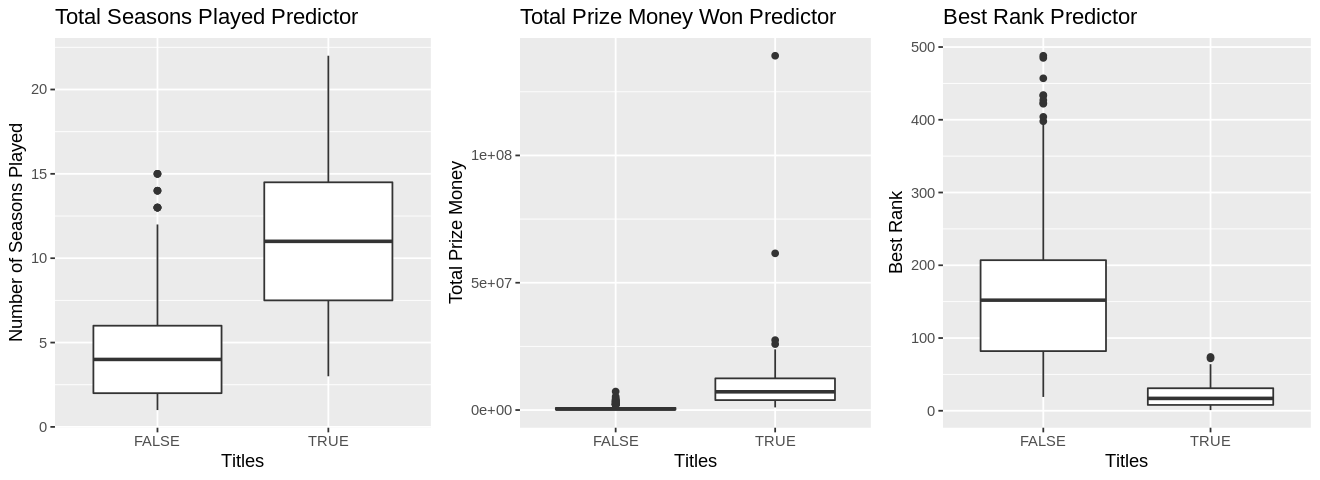

In [6]:
options(repr.plot.width = 11, repr.plot.height = 4)
plot_best_rank <- tennis_train |>
    ggplot(aes(x = Titles, y = best.rank)) +
    geom_boxplot() +
    ylab("Best Rank") +
    ggtitle("Best Rank Predictor")
plot_seasons <- tennis_train |>
    ggplot(aes(x = Titles, y = Seasons)) +
    geom_boxplot() +
    ylab("Number of Seasons Played") +
    ggtitle("Total Seasons Played Predictor")
plot_prize_money <- tennis_train |>
    ggplot(aes(x = Titles, y = Prize.Money)) +
    geom_boxplot() +
    ylab("Total Prize Money") +
    ggtitle("Total Prize Money Won Predictor")


plot_grid(plot_seasons, plot_prize_money, plot_best_rank, nrow = 1)

### Methods

In order to perform a K-nearest neighbors classification, we will first tidy the data set and split it into training and testing data. We will also center and scale the data so that the classification is not overly influenced by one predictor. Then, we will use cross-validation to tune the model and find the K-value with the highest accuracy. With that K-value, we will fit it to the training data, use that to predict the testing data, and see how accurate the model actually is. One way that we will visualize the results is by making a table showing the confusion matrix of the predictions compared to the actual data.

The predictor variables we have chosen from this data set are best rank, number of seasons played and age. These were chosen as we see them as the most relevant in differentiating players and describing their success in playing tennis. Their best rank gives us information on how well they play compared to other players while number of seasons played and age shows a players experience, all of which should be strong indicators of their ability to play tennis.

In [13]:
# Scale and Center Recipe
tennis_recipe <- recipe(Titles ~ Seasons + best.rank + Prize.Money, data = tennis_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# KNN Tune Model Specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Cross Validation
training_vfold <- vfold_cv(tennis_train, v = 10, strata = Titles)

# K Values Vector
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

# Training Fit Workflow
training_fit <- workflow() |>
    add_recipe(tennis_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = training_vfold, grid = k_vals) |>
    collect_metrics()

In [15]:
# Best K neighbors
best_k <- training_fit |>
    filter(.metric == "accuracy") |>
    arrange(mean) |>
    tail(1) |>
    select(neighbors) |>
    pull()

# KNN Specification with best K
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Final Model Workflow
tennis_fit <- workflow() |>
    add_recipe(tennis_recipe) |>
    add_model(best_spec) |>
    fit(data = tennis_train)

# Model Predictions
tennis_predictions <- predict(tennis_fit, tennis_test) |>
    bind_cols(tennis_test)

# Model Prediction Metrics
tennis_metrics <- tennis_predictions |>
    metrics(truth = Titles, estimate = .pred_class)

# Model Confusion Matrix
tennis_conf_mat <- tennis_predictions |>
    conf_mat(truth = Titles, estimate = .pred_class)

tennis_metrics
tennis_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9175258
kap,binary,0.7721668


          Truth
Prediction FALSE TRUE
     FALSE    70    5
     TRUE      3   19

### Expected Outcomes and Significance

Through this exploration we believe that our model will be fairly capable at predicting whether a given player has won a title before given the variables of best rank, age, number of seasons played, historical prize money won, and age. Such a model could be helpful for players in determining where they stand amongst their competition as we build a better understanding of what goes into making a title-holding tennis player. A future project could look into determining whether or not a player will win a title given their stats and also information about the specific tournament they will play in. Can we predict the likelihood a given player will win a match? How accurate can this prediction be? Such questions could be very significant for the sports betting industry. As silly as that may sound, sports betting can play a significant role in generating revenue for the government through taxation. In 2022 sports betting set a quarterly revenue record of 1.68 billion dollars in the United States (Greenburg). Given these circumstances, being able to predict the outcome for a sport in any capacity could lead to a significant pay off.  


### Citations

Greenberg, D. (2022) *Sports betting industry just set a quarterly revenue record, Front Office Sports.* Available at: https://frontofficesports.com/sports-betting-industry-just-set-a-quarterly-revenue-record/ (Accessed: March 11, 2023). 
